# Part1 - Theoretical logic

generalization error smaller than $\epsilon \leq 0.3$ with a probability of $1-δ = 80$% we need sample size $m$ :
--
$m \geq  \frac {log_e(\frac {|H|}{δ})}{\epsilon}$

$m \geq  \frac {log_e(\frac {|2001|}{0.2})}{0.3} \approx 30.71$

so we need sample size $ m = 31$

# Part2

## Module import

In [ ]:
import random  # Ensure the random module is imported
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots



## Passive learner algorithem


In [21]:
def Passive_algo(samples):
    max_0 = float('-inf')
    min_1 = float('inf')

    for sample, label in samples:
        if label == 0:
            max_0 = max(max_0, sample)
        elif label == 1:
            min_1 = min(min_1, sample)

    return (max_0+min_1)/2



In [22]:
def generate_random_threshold(startrange,endrange):
    """
    Generates a random integer between -1000 and 1000.

    Returns:
        int: A random integer between -1000 and 1000.
    """
    return random.randint(-1000, 1000)

In [23]:
def generate_samples(num_samples, threshold,startrange,endrange):
    """
    Generates a list of random samples with labels based on a threshold.

    Args:
        num_samples (int): The number of samples to generate.
        threshold (int): The threshold value to determine the labels.

    Returns:
        list of tuple: A list of tuples where each tuple contains:
                       - int: A random sample value between -1000 and 1000.
                       - int: A label (0 if the value is below the threshold, 1 otherwise).
    """
    samples = []
    for _ in range(num_samples):
        sample_value = random.randint(startrange,endrange)  # Generate random sample value
        label = 0 if sample_value < threshold else 1  # Assign label based on threshold
        samples.append((sample_value, label))
    return samples

In [24]:
def compute_error(threshold, estimated_threshold,range):
    """
    Computes the error as the normalized absolute difference between
    the actual threshold and the estimated threshold.

    Args:
        threshold (int): The actual threshold value.
        estimated_threshold (int): The estimated threshold value.

    Returns:
        float: The error, normalized by dividing the absolute difference
               by 2000.
    """
    return abs(threshold - estimated_threshold) / range

In [25]:
def run_simulation(trials, sample_sizes, threshold,startrange,endrange,errorlimit):
    """
    Runs a simulation to estimate probabilities and confidence intervals
    for a threshold prediction algorithm.

    Args:
        trials (int): The number of trials for each sample size.
        sample_sizes (list of int): A list of sample sizes for the simulation.
        threshold (int): The true threshold used for comparison.

    Returns:
        tuple:
            - list of float: A list of probabilities for each sample size.
            - list of float: A list of confidence intervals (width) for the probabilities.
    """
    probabilities = []
    confidence_intervals = []

    for size in sample_sizes:
        errors = []

        for _ in range(trials):
            samples = generate_samples(size, threshold,startrange,endrange)
            estimated_threshold = Passive_algo(samples)
            error = compute_error(threshold, estimated_threshold,endrange-startrange)
            errors.append(error < errorlimit)  # Check if error is below 30%

        prob = np.mean(errors)  # Calculate the average probability
        ci = 1.28 * np.std(errors) / np.sqrt(trials)  # 80% confidence interval
        probabilities.append(prob)
        confidence_intervals.append(ci)


    return probabilities, confidence_intervals

In [26]:
def ploti():
    random.seed(12)
    startrange = -1000
    endrange = 1000
    errorlimit = 0.3
    threshold = random.randint(startrange, endrange)
    print(f"True Threshold: {threshold}")

    sample_sizes = range(1, 33, 2)
    trials = 1000  # Number of simulations

    probabilities, confidence_intervals = run_simulation(trials, sample_sizes, threshold, startrange, endrange,errorlimit)

    # Create interactive Plotly scatter plot
    fig = go.Figure()

    # Add scatter plot with error bars
    fig.add_trace(go.Scatter(
        x=list(sample_sizes),
        y=probabilities,
        mode='markers+lines',
        error_y=dict(
            type='data',
            array=confidence_intervals,
            visible=True
        ),
        hovertemplate=(
            "<b>Sample Size:</b> %{x}<br>"
            "<b>Probability:</b> %{y:.2f}<br>"
            "<b>Confidence Interval:</b> ±%{error_y.array:.2f}<extra></extra>"
        ),
        name="Empirical Probability"
    ))

    # Add horizontal line for 80% confidence
    fig.add_trace(go.Scatter(
        x=[min(sample_sizes), max(sample_sizes)],
        y=[0.8, 0.8],
        mode='lines',
        line=dict(dash='dash', color='red'),
        name="80% Confidence"
    ))

    # Update layout with title and subtitle
    fig.update_layout(
        title={
            'text': f"Probability of Generalization Error < <b>{errorlimit*100}%</b> vs Sample Size<br><br>"
                    f"<sup>From :  {startrange} , To : {endrange}</sup>",
            'x': 0.5,  # Center the title
        },
        xaxis_title="Sample Size",
        yaxis_title="Probability",
        legend_title="Legend",
        template="plotly_white"
    )

    # Show the plot
    fig.show()

ploti()


True Threshold: -29


### More simulations differnet errorrate limit and differnet intervals

In [27]:
def ploti_for_intervals(intervals,errorlimit):
    # Create a grid of subplots
    fig = make_subplots(
        rows=2, cols=3,  # 2 rows, 3 columns (one cell will be empty)
        subplot_titles=[
            f"From: {start}, To: {end}" for start, end in intervals
        ]
    )

    for i, (startrange, endrange) in enumerate(intervals):
        row, col = divmod(i, 3)  # Determine row and column for each subplot
        row += 1
        col += 1

        random.seed(12)
        threshold = random.randint(startrange, endrange)
        print(f"True Threshold for Interval {startrange} to {endrange}: {threshold}")

        sample_sizes = list(range(1, 33, 2))
        trials = 1000  # Number of simulations

        probabilities, confidence_intervals = run_simulation(trials, sample_sizes, threshold, startrange, endrange,errorlimit)

        # Find the first sample size where probability crosses 80%
        crossing_index = next((idx for idx, prob in enumerate(probabilities) if prob >= 0.8), None)
        crossing_sample_size = sample_sizes[crossing_index] if crossing_index is not None else None

        # Add scatter plot with error bars to the subplot
        fig.add_trace(
            go.Scatter(
                x=sample_sizes,
                y=probabilities,
                mode='markers+lines',
                error_y=dict(
                    type='data',
                    array=confidence_intervals,
                    visible=True
                ),
                name=f"Interval {startrange} to {endrange}",
                hovertemplate=(
                    "<b>Sample Size:</b> %{x}<br>"
                    "<b>Probability:</b> %{y:.2f}<br>"
                    "<b>Confidence Interval:</b> ±%{error_y.array:.2f}<extra></extra>"
                )
            ),
            row=row, col=col
        )

        # Add horizontal line for 80% confidence
        fig.add_trace(
            go.Scatter(
                x=[min(sample_sizes), max(sample_sizes)],
                y=[0.8, 0.8],
                mode='lines',
                line=dict(dash='dash', color='red'),
                showlegend=False  # Avoid repeated legend items
            ),
            row=row, col=col
        )

        # Add vertical line and annotation if crossing point exists
        if crossing_sample_size:
            # Add vertical line
            fig.add_trace(
                go.Scatter(
                    x=[crossing_sample_size, crossing_sample_size],
                    y=[0, 1],  # Vertical line spans the entire y-range
                    mode='lines',
                    line=dict(dash='dot', color='blue'),
                    showlegend=False
                ),
                row=row, col=col
            )

            fig.add_annotation(
    x=crossing_sample_size,
    y=0,  # Position at the bottom (near the x-axis)
    text=f"x = {crossing_sample_size}",
    ax=0,  # Keep the arrow horizontal
    ay=20,  # Arrow points upwards slightly above the text
    row=row,
    col=col
)

    # Update layout with a common title and axis labels
    fig.update_layout(
        title=f"Probability of Generalization Error < <b>{errorlimit*100}%</b> for Different Ranges",
        xaxis_title="Sample Size",
        yaxis_title="Probability",
        template="plotly_white",
        height=800,  # Adjust height for better visualization
    )

    # Show the plot
    fig.show()



In [28]:
# Define the intervals
intervals = [(-200,200),(-1000, 1000), (-2000, 2000), (-3000, 3000), (-5000, 5000), (-10000, 10000)]
errorlimit = [0.01,0.05,0.1,0.3]
# Plot the graphs for the intervals
for error in errorlimit:
  ploti_for_intervals(intervals,error)


True Threshold for Interval -200 to 200: 42
True Threshold for Interval -1000 to 1000: -29
True Threshold for Interval -2000 to 2000: -57
True Threshold for Interval -3000 to 3000: 887
True Threshold for Interval -5000 to 5000: 2775
True Threshold for Interval -10000 to 10000: 5550


True Threshold for Interval -200 to 200: 42
True Threshold for Interval -1000 to 1000: -29
True Threshold for Interval -2000 to 2000: -57
True Threshold for Interval -3000 to 3000: 887
True Threshold for Interval -5000 to 5000: 2775
True Threshold for Interval -10000 to 10000: 5550


True Threshold for Interval -200 to 200: 42
True Threshold for Interval -1000 to 1000: -29
True Threshold for Interval -2000 to 2000: -57
True Threshold for Interval -3000 to 3000: 887
True Threshold for Interval -5000 to 5000: 2775
True Threshold for Interval -10000 to 10000: 5550


True Threshold for Interval -200 to 200: 42
True Threshold for Interval -1000 to 1000: -29
True Threshold for Interval -2000 to 2000: -57
True Threshold for Interval -3000 to 3000: 887
True Threshold for Interval -5000 to 5000: 2775
True Threshold for Interval -10000 to 10000: 5550


## Active Algorithem Learner

In [14]:
def labeling_function(threshold, number):
    """
    Simulates a labeling function.

    Args:
        threshold (int): The true threshold value.
        number (int): The number to label.

    Returns:
        int: The label (0 if number < threshold, 1 otherwise).
    """
    return 0 if number < threshold else 1

In [15]:
def active_learner(threshold, max_iterations , startrange , endrange):
    """
    Simulates the active learning algorithm using binary search.

    Args:
        threshold (int): The true threshold value.
        max_iterations (int): The number of iterations to perform.

    Returns:
        int: The estimated threshold.
    """
    left, right = startrange , endrange  # Define the search space
    for _ in range(max_iterations):
        mid = (left + right) // 2  # Compute the midpoint
        label = labeling_function(threshold, mid)  # Query the labeling function
        if label == 0:
            left = mid + 1  # Narrow the search to the right half
        else:
            right = mid  # Narrow the search to the left half
    return left  # Return the estimated threshold

In [16]:
def simulation(min_iterations, max_iterations,true_threshold, startrange , endrange):
    """
    Simulates the active learning process over a range of iteration counts.

    Args:
        min_iterations (int): Minimum number of iterations to test.
        max_iterations (int): Maximum number of iterations to test.

    Returns:
        list of tuple: A list where each tuple contains:
                       - int: Number of iterations.
                       - int: True threshold.
                       - int: Estimated threshold.
    """
    results = []
    for iterations in range(min_iterations, max_iterations + 1):
        estimated_threshold = active_learner(true_threshold, iterations, startrange , endrange)
        error = compute_error(true_threshold, estimated_threshold, endrange-startrange )
        # Store the result
        results.append((iterations,estimated_threshold,error))
    return results


Iterations: 2, True Threshold: -4631, Estimated Threshold: -49999, Error: 0.2268
Iterations: 3, True Threshold: -4631, Estimated Threshold: -24999, Error: 0.1018
Iterations: 4, True Threshold: -4631, Estimated Threshold: -12499, Error: 0.0393
Iterations: 5, True Threshold: -4631, Estimated Threshold: -6249, Error: 0.0081
Iterations: 6, True Threshold: -4631, Estimated Threshold: -6249, Error: 0.0081
Iterations: 7, True Threshold: -4631, Estimated Threshold: -4686, Error: 0.0003
Iterations: 8, True Threshold: -4631, Estimated Threshold: -4686, Error: 0.0003


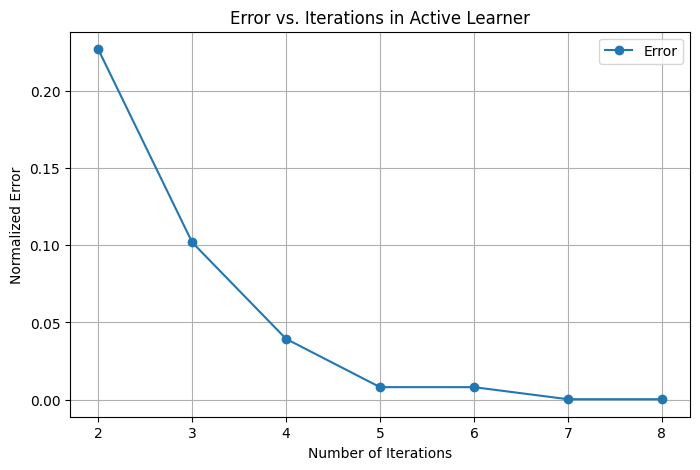

In [17]:
startrange = -100000
endrange = 100000
true_threshold = random.randint( startrange , endrange)


# Example 3: Run the simulation
results = simulation(2, 8,true_threshold, startrange , endrange)
for iterations, estimated_threshold, error in results:
    print(f"Iterations: {iterations}, True Threshold: {true_threshold}, Estimated Threshold: {estimated_threshold}, Error: {error:.4f}")

# Plotting the results
iterations_list = [r[0] for r in results]
errors = [r[2] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(iterations_list, errors, marker='o', label='Error')
plt.title('Error vs. Iterations in Active Learner')
plt.xlabel('Number of Iterations')
plt.ylabel('Normalized Error')
plt.grid(True)
plt.legend()
plt.show()

# Part3 - discussion

## Part 3: Discussion

### 1. Compare Theoretical and Empirical Results

- **Theoretical Sample Size:**
  According to the formula, the theoretical sample size required to achieve a generalization error smaller than $ \epsilon \leq 0.3 $ with a confidence of $1 - \delta = 80\%$ is calculated as:

  $
  m \geq \frac{\log(\frac{H}{\delta})}{\epsilon}
  $

  Substituting the values:

  $
  m \geq \frac{\log(\frac{2001}{0.2})}{0.3} \approx 30.71
  $

  Hence, $ m = 31 $ samples are needed theoretically.

- **Empirical Results:**
  The empirical graph shows that the probability of the generalization error being smaller than $30\%$ crosses the $80\%$ confidence threshold (red dashed line) with a sample size of around $ m \approx 5 $, which is much smaller than the theoretical value.

- **Why the Difference?**
  1. **Conservative Theoretical Bounds:** The theoretical bounds are derived under worst-case assumptions (e.g., Hoeffding’s inequality) and tend to be overly cautious.
  2. **Data Structure:** The actual data distribution might have less variability or complexity compared to what is assumed in the theoretical derivation.
  3. **Hypothesis Complexity ($H$):** The real-world hypothesis class might be smaller or simpler than the assumed $ H $ in the theoretical calculation.

---

### 2. Passive vs. Active Learning

#### **Sample Size Requirements:**
- **Passive Learning:**
  In passive learning, the sample size is fixed and usually much larger. For example, the theoretical bound requires $ m = 31 $ samples to achieve the desired confidence level.

- **Active Learning:**
  In active learning, the model selects the most informative samples, which significantly reduces the number of samples needed. From the active learning plot, the normalized error approaches zero in only $8$ iterations.

#### **Advantages and Disadvantages:**

| **Learning Strategy** | **Advantages**                                                                | **Disadvantages**                                                                |
|------------------------|-------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| **Passive Learning**   | - Simple to implement (random sampling).                                      | - Inefficient as it requires more samples.                                       |
|                        | - Does not rely on any assumptions about data informativeness.                | - May not focus on the most critical regions of the data.                        |
| **Active Learning**    | - More efficient sampling, requiring fewer labeled examples.                  | - Requires retraining the model after each new sample, which can be computationally expensive. |
|                        | - Focuses on the most uncertain or informative samples.                       | - Needs a well-defined strategy to measure informativeness.                      |

#### **Impact of Selective Sampling:**
- In **active learning**, the ability to select the most informative samples accelerates the learning process. By focusing on areas with high uncertainty (e.g., near decision boundaries), active learning achieves lower generalization error with fewer samples.
- In **passive learning**, random sampling often includes less informative points, which leads to slower error reduction and higher data requirements.

---

**Conclusion:**
Active learning demonstrates significantly better efficiency in terms of sample size compared to passive learning. However, its practical implementation might require additional computational resources and thoughtful design of selection strategies.
